In [37]:
%cd /home/Reguformer/notebooks

/home/Reguformer/notebooks


In [38]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from copy import deepcopy
from tqdm import tqdm

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from scipy.spatial.distance import cosine

import warnings
warnings.filterwarnings('ignore')

from trans_oil_gas import utils_dataset, utils_attn, utils_fix_seeds, utils_model

Set parameters for plots.

In [39]:
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

Choose GPU device if it is available.

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gpu = [0] if 'cuda' in device.type else 0
device, gpu

(device(type='cpu'), 0)

Fix all possible seeds for results reproducibility.

In [41]:
utils_fix_seeds.fix_seeds(device=device)

# Read data

Reading of already preprocessed data (here synthetic dataset with the same columns as in the original one is presented).

In [42]:
df = pd.read_csv('../data/synthetic_well_log_data.csv')
df

,DRHO,DENS,GR,DTC,WELLNAME
0,0.01778,2.3794,1.214982,101.5516,26
1,0.01701,2.3705,1.086457,101.6722,26
2,0.01624,2.3615,0.957933,101.7928,26
3,0.01779,2.3593,0.493992,101.1051,26
4,0.02008,2.3591,-0.076734,100.1601,26
...,...,...,...,...,...
730,0.11269,2.6161,0.742381,92.0410,127
731,0.11269,2.6161,0.775581,92.1752,127
732,0.11269,2.6161,0.686798,91.6055,127
733,0.11269,2.6161,0.614402,91.7522,127


In [43]:
slice_len = 100
well_column = "WELLNAME"
path_to_save = './saves_robustness'

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

# Generate dataset and create dataloader

In [44]:
_, val_slice_dataset = utils_dataset.generate_datasets(
    df, df,
    well_column='WELLNAME',
    slice_len=slice_len,
    path_to_saves=path_to_save,
    results_len_train=0,
    # results_len_test=5000,
    results_len_test=50,
)    

In [45]:
batch_size = 64

In [46]:
val_dataloader = DataLoader(
    val_slice_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

# Models' params

In [47]:
shared_fixed_params = {
    "enc_in": 4,
    "distil": None,
    "device": device,
    "output_attention": False,
    "n_seq": 100
}
fixed_params_tr = {
    "attn": "full",
    "activation": "relu",
}
fixed_params_reguformer = {
    "attn": "prob",
    "activation": "gelu",
}

In [48]:
path_to_models = "./saves_all_models/"

# Elimination of parts of well-intervals with 0s or white noise

In [49]:
# P = [i * 10 for i in range(1, 10)]
P = [i * 10 for i in range(1, 3)]

In [50]:
def get_proba(model, model_type, slice_1, slice_2, distance_type):
    if "siamese" in model_type and distance_type == "None":
        return model((slice_1, slice_2)).detach().cpu().numpy()[:, 0]
    
    pred_1 = model.encode(slice_1).detach().cpu().numpy()
    pred_2 = model.encode(slice_2).detach().cpu().numpy()
    
    if distance_type == "euclidean":
        dist_12 = np.linalg.norm(pred_1 - pred_2, ord=2, axis=1)
        return 1 / (1 + dist_12)
    elif distance_type == "cosine":
        dist_12 = np.array(
            [cosine(pred_1[i], pred_2[i]) for i in range(len(pred_1))]
        )
        return 1 - dist_12

In [51]:
ans = {
    "model_type": [], 
    "loss_type": [], 
    "reg_type": [], 
    "p": [], 
    "elimination_type": [], 
    "acc": [], 
    "roc_auc": [], 
    "pr_auc": [],
    "distance_type": [],
}
all_distances = ["None", "euclidean", "cosine"]

for loss_type in ["siamese", "triplet"]:
    for model_type in [
        "None",
        "topQ",  
        "topK",  
        "topQ_topK",
        "randQ_randK",
    ]:
        print(loss_type, model_type)
        with open(os.path.join(path_to_models, "best_params_{}_reguformer_{}.json".format(loss_type, model_type)), "r") as f:
            best_params = json.load(f)
        
        if "None" in model_type:
            fixed_params = deepcopy(fixed_params_tr)
            enc_type = "transformer"
            reg_type = ""
        else:
            fixed_params = deepcopy(fixed_params_reguformer)
            enc_type = "reguformer"
            reg_type = "_" + model_type

        if "siamese" in loss_type:
            model = utils_model.SiameseArchitecture(
                encoder_type="reguformer", 
                fc_hidden_size=64, 
                **shared_fixed_params, 
                **fixed_params,
                **best_params,
            ).float()
            distances = deepcopy(all_distances)

        elif "triplet" in loss_type:
            model = utils_model.TripletArchitecture(
                encoder_type="reguformer", 
                **shared_fixed_params, 
                **fixed_params,
                **best_params,
            ).float()
            distances = all_distances[1:]

        print('loading model...')
        model.load_state_dict(torch.load(os.path.join(path_to_models, "res_{}_{}{}.pth".format(loss_type, enc_type, reg_type)), map_location=device))
        print('model loaded')
        model.eval()
        model = model.to(device)

        for p in P:
            for slice_1, positive, negative, well in tqdm(val_dataloader):
                slice_1 = slice_1.to(device)
                slice_1_r_0 = utils_attn.robustness_test(
                    slice_1,
                    fill_with='zeros',
                    p=p / 100,
                ) 
                slice_1_r_r = utils_attn.robustness_test(
                    slice_1,
                    fill_with='rand',
                    p=p / 100,
                )
                targets = np.array([])
                probas = {
                    "None": {"init": np.array([]), "rand_0": np.array([]), "rand_rand": np.array([])},
                    "euclidean": {"init": np.array([]), "rand_0": np.array([]), "rand_rand": np.array([])},
                    "cosine": {"init": np.array([]), "rand_0": np.array([]), "rand_rand": np.array([])},
                }
                for slice_2, target in zip(
                    [positive, negative],
                    [np.ones(slice_1.shape[0]), np.zeros(slice_1.shape[0])]
                ):
                    slice_2 = slice_2.to(device)
                    slice_2_r_0 = utils_attn.robustness_test(
                        slice_2, 
                        fill_with='zeros',
                        p=p / 100,
                    ) 
                    slice_2_r_r = utils_attn.robustness_test(
                        slice_2, 
                        fill_with='rand',
                        p=p / 100,
                    )
                    targets = np.concatenate([targets, target])
                    
                    for dist_type in distances:
                        for intervals_type, slices in zip(
                            ["init", "rand_0", "rand_rand"],
                            [
                                {"slice_1": slice_1, "slice_2": slice_2}, 
                                {"slice_1": slice_1_r_0, "slice_2": slice_2_r_0}, 
                                {"slice_1": slice_1_r_r, "slice_2": slice_2_r_r},
                            ],
                        ):
                            probas[dist_type][intervals_type] = np.concatenate(
                                [
                                    probas[dist_type][intervals_type], 
                                    get_proba(model=model, model_type=model_type+"-"+loss_type, distance_type=dist_type, **slices),
                                ]
                            )

                for dist_type in distances:
                    for elimination_type in ["init", "rand_0", "rand_rand"]:
                        ans["distance_type"].append(dist_type)
                        ans["elimination_type"].append(elimination_type)
                        ans["model_type"].append(model_type+"-"+loss_type)
                        ans["loss_type"].append(loss_type)
                        ans["reg_type"].append(reg_type[1:])
                        ans["p"].append(p)
                        for metric_name, metric in zip(
                            ["acc", "roc_auc", "pr_auc"],
                            [accuracy_score, roc_auc_score, average_precision_score],
                        ):
                            proba = probas[dist_type][elimination_type]

                            if metric_name == "acc":
                                proba = (proba > 0.5).astype(int)
                                
                            ans[metric_name].append(metric(targets, proba))

  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

siamese None
loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

siamese topQ
loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

siamese topK
loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

siamese topQ_topK
loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

siamese randQ_randK
loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

triplet None
loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

triplet topQ
loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

triplet topK
loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

triplet topQ_topK
loading model...
model loaded


  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

triplet randQ_randK
loading model...
model loaded


100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.02s/it]


In [52]:
ans_df = pd.DataFrame(ans)
ans_df.to_csv(os.path.join(path_to_save, 'robustness_all_models_metrics.csv'), index=False)
ans_df

,model_type,loss_type,reg_type,p,elimination_type,acc,roc_auc,pr_auc,distance_type
0,None-siamese,siamese,,10,init,0.66,0.6828,0.710654,None
1,None-siamese,siamese,,10,rand_0,0.59,0.6124,0.619756,None
2,None-siamese,siamese,,10,rand_rand,0.59,0.6212,0.649824,None
3,None-siamese,siamese,,10,init,0.91,0.9572,0.963811,euclidean
4,None-siamese,siamese,,10,rand_0,0.84,0.9200,0.893944,euclidean
...,...,...,...,...,...,...,...,...,...
145,randQ_randK-triplet,triplet,randQ_randK,20,rand_0,0.53,0.9296,0.934743,euclidean
146,randQ_randK-triplet,triplet,randQ_randK,20,rand_rand,0.50,0.9228,0.909868,euclidean
147,randQ_randK-triplet,triplet,randQ_randK,20,init,0.82,0.9440,0.949606,cosine
148,randQ_randK-triplet,triplet,randQ_randK,20,rand_0,0.69,0.9320,0.937457,cosine


## Results analysis

In [53]:
ans_df = pd.read_csv(os.path.join(path_to_save, 'robustness_all_models_metrics.csv'))
ans_df

,model_type,loss_type,reg_type,p,elimination_type,acc,roc_auc,pr_auc,distance_type
0,None-siamese,siamese,NaN,10,init,0.66,0.6828,0.710654,None
1,None-siamese,siamese,NaN,10,rand_0,0.59,0.6124,0.619756,None
2,None-siamese,siamese,NaN,10,rand_rand,0.59,0.6212,0.649824,None
3,None-siamese,siamese,NaN,10,init,0.91,0.9572,0.963811,euclidean
4,None-siamese,siamese,NaN,10,rand_0,0.84,0.9200,0.893944,euclidean
...,...,...,...,...,...,...,...,...,...
145,randQ_randK-triplet,triplet,randQ_randK,20,rand_0,0.53,0.9296,0.934743,euclidean
146,randQ_randK-triplet,triplet,randQ_randK,20,rand_rand,0.50,0.9228,0.909868,euclidean
147,randQ_randK-triplet,triplet,randQ_randK,20,init,0.82,0.9440,0.949606,cosine
148,randQ_randK-triplet,triplet,randQ_randK,20,rand_0,0.69,0.9320,0.937457,cosine


4it [00:00, 46.41it/s]
4it [00:00, 88.22it/s]
4it [00:00, 92.19it/s]
4it [00:00, 90.28it/s]
4it [00:00, 90.14it/s]
4it [00:00, 91.51it/s]
4it [00:00, 90.72it/s]
4it [00:00, 89.53it/s]
4it [00:00, 92.56it/s]
4it [00:00, 91.90it/s]
4it [00:00, 92.27it/s]
4it [00:00, 89.53it/s]
4it [00:00, 89.65it/s]
4it [00:00, 88.42it/s]
4it [00:00, 90.38it/s]


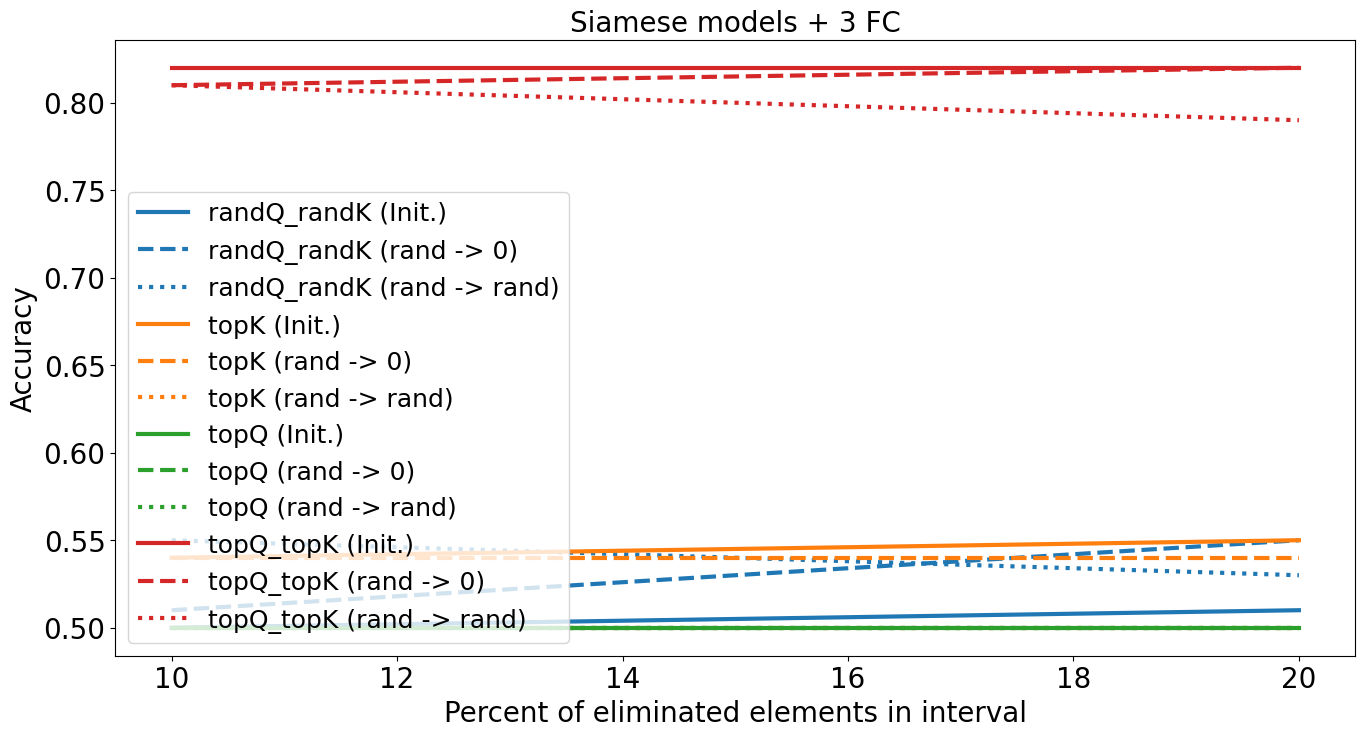

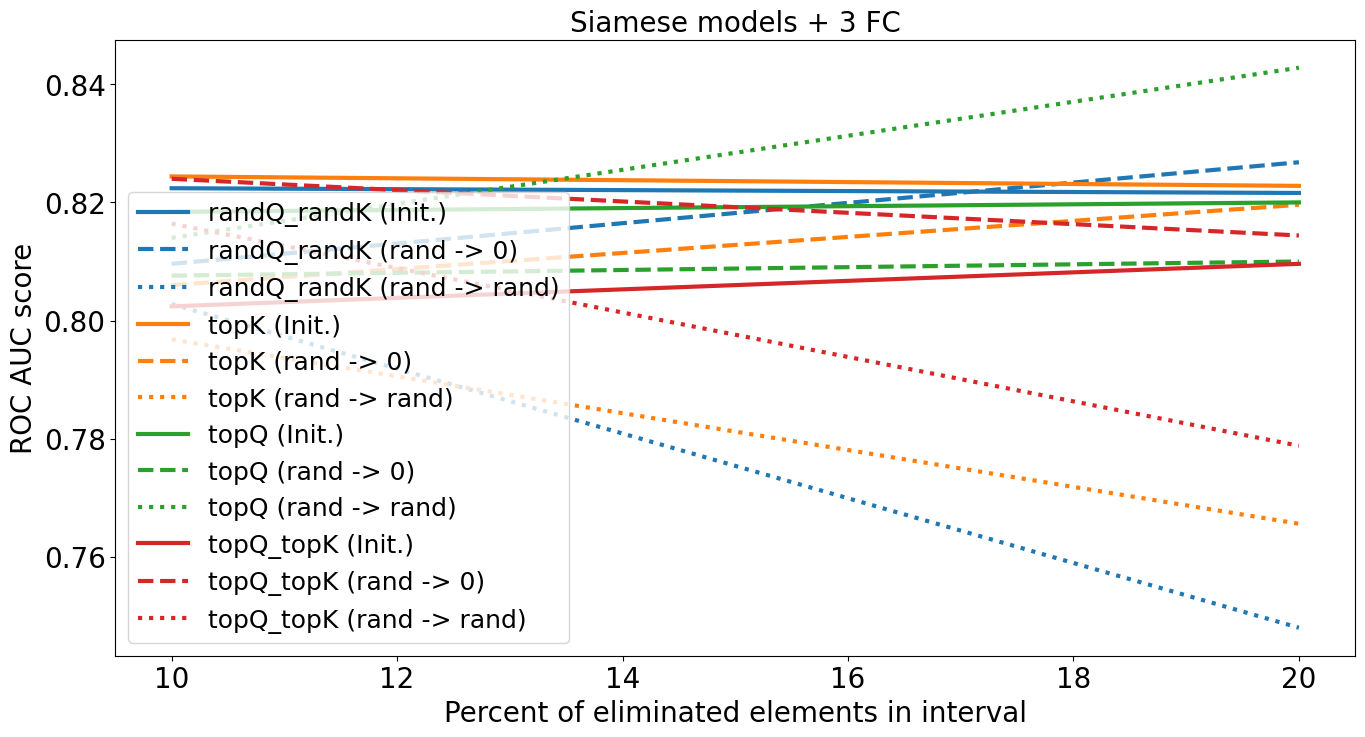

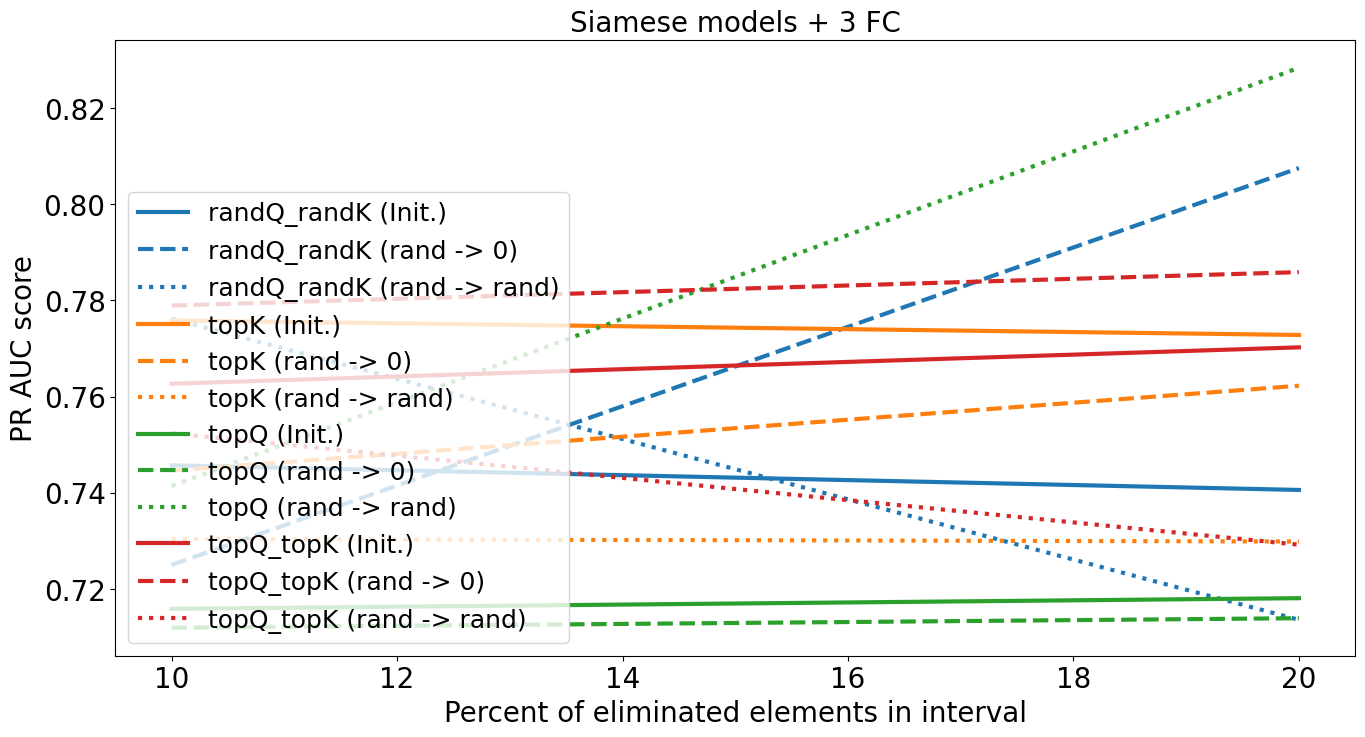

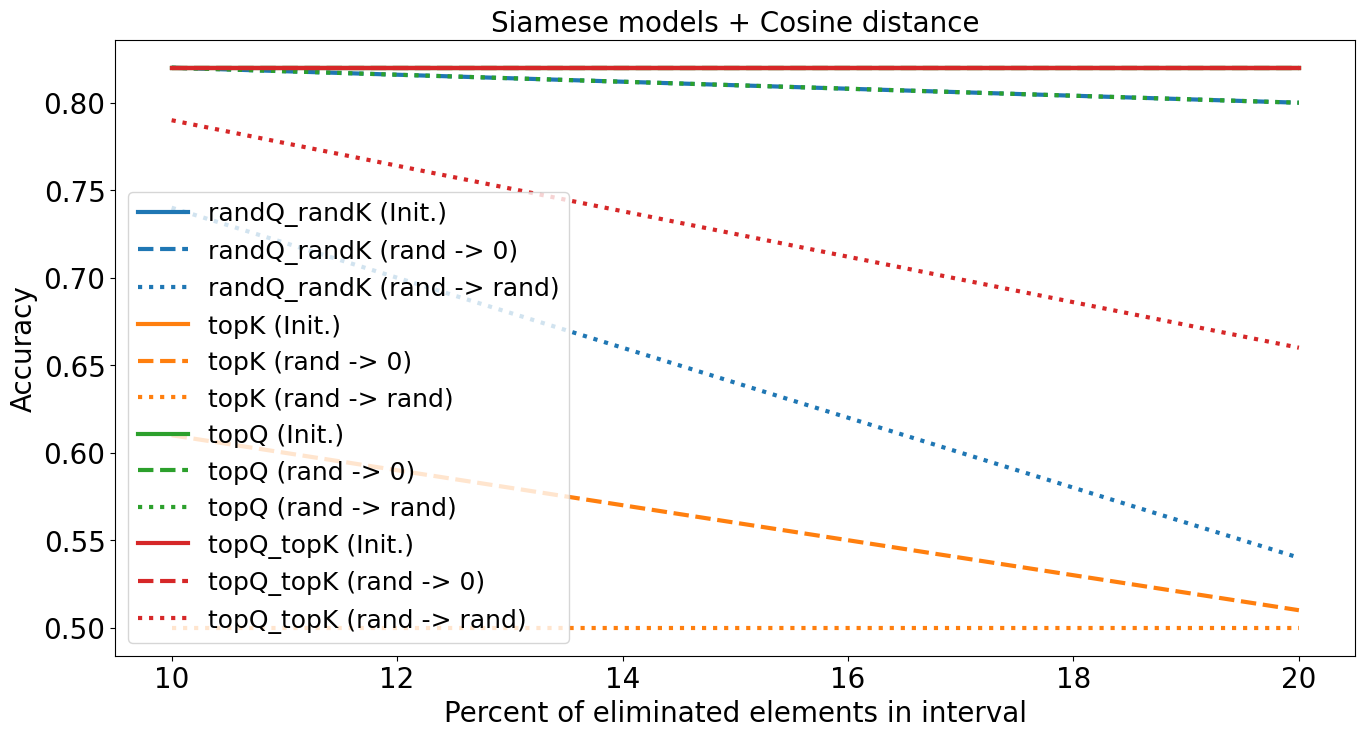

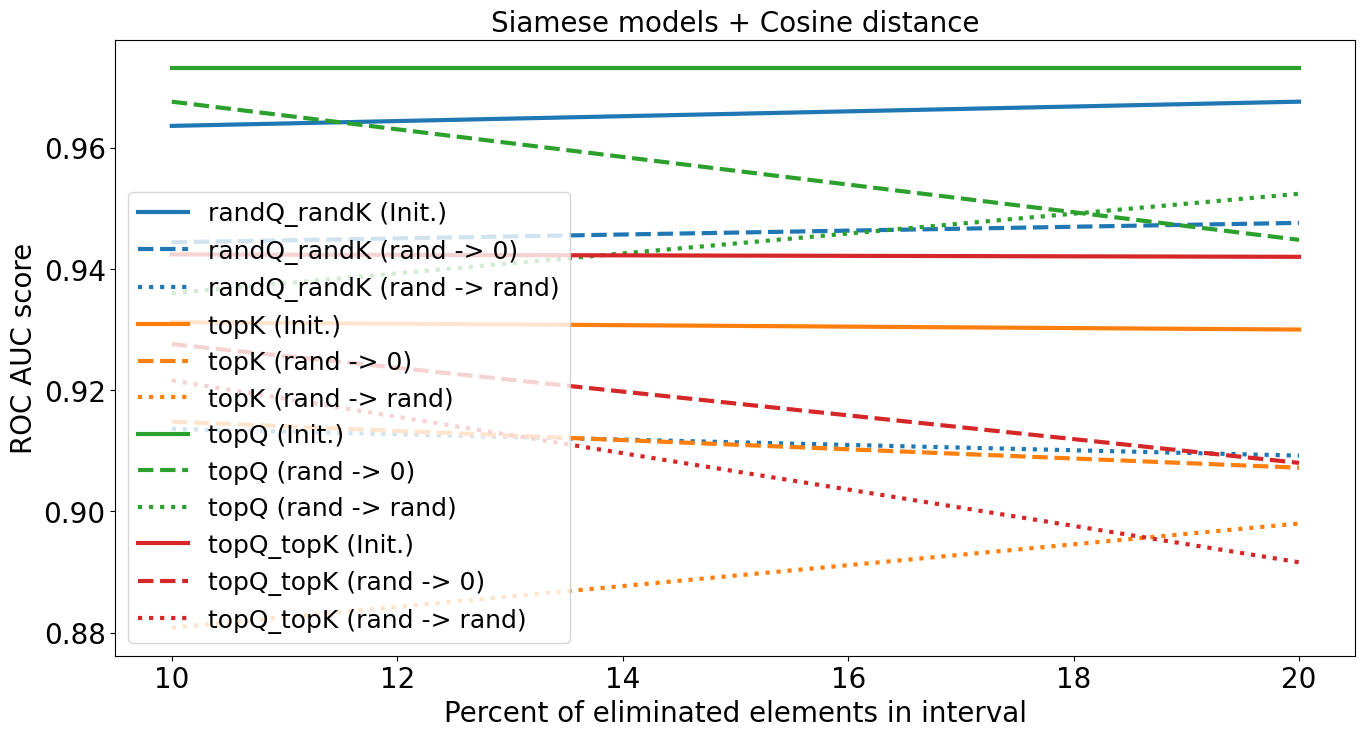

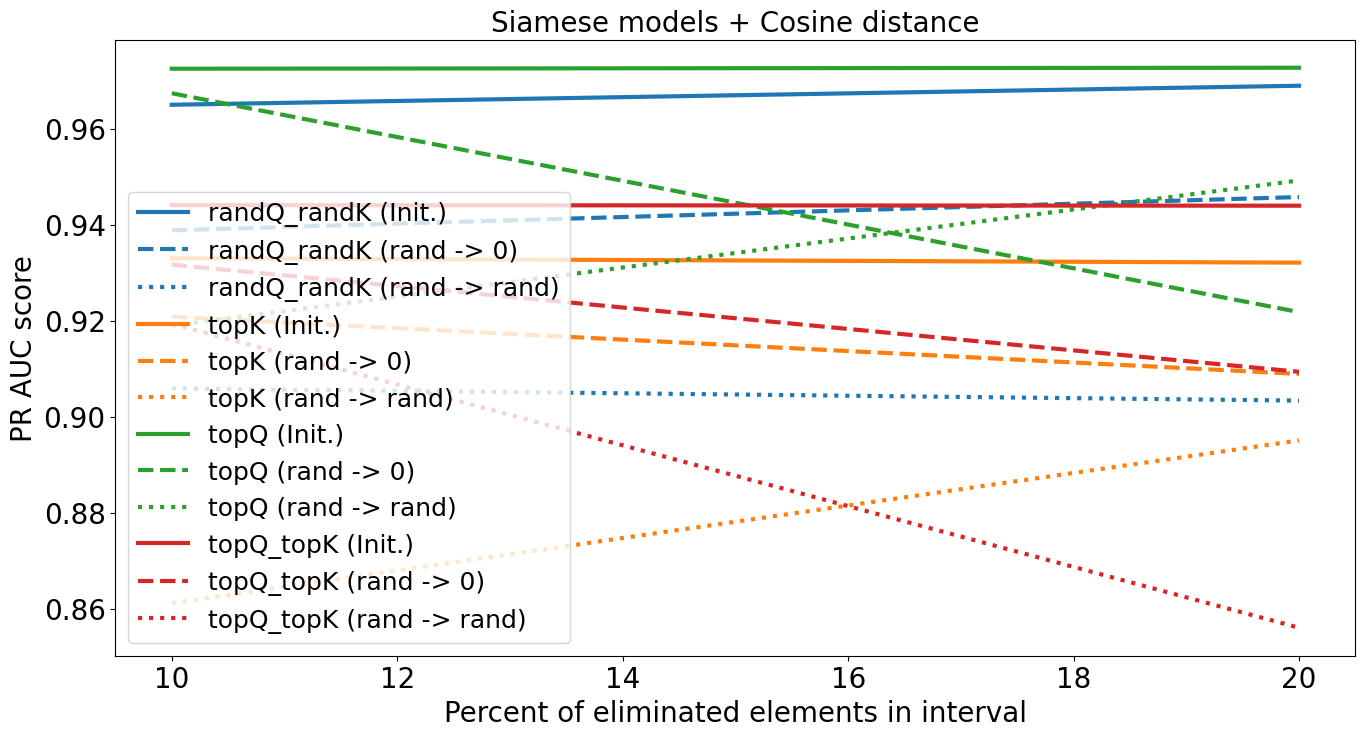

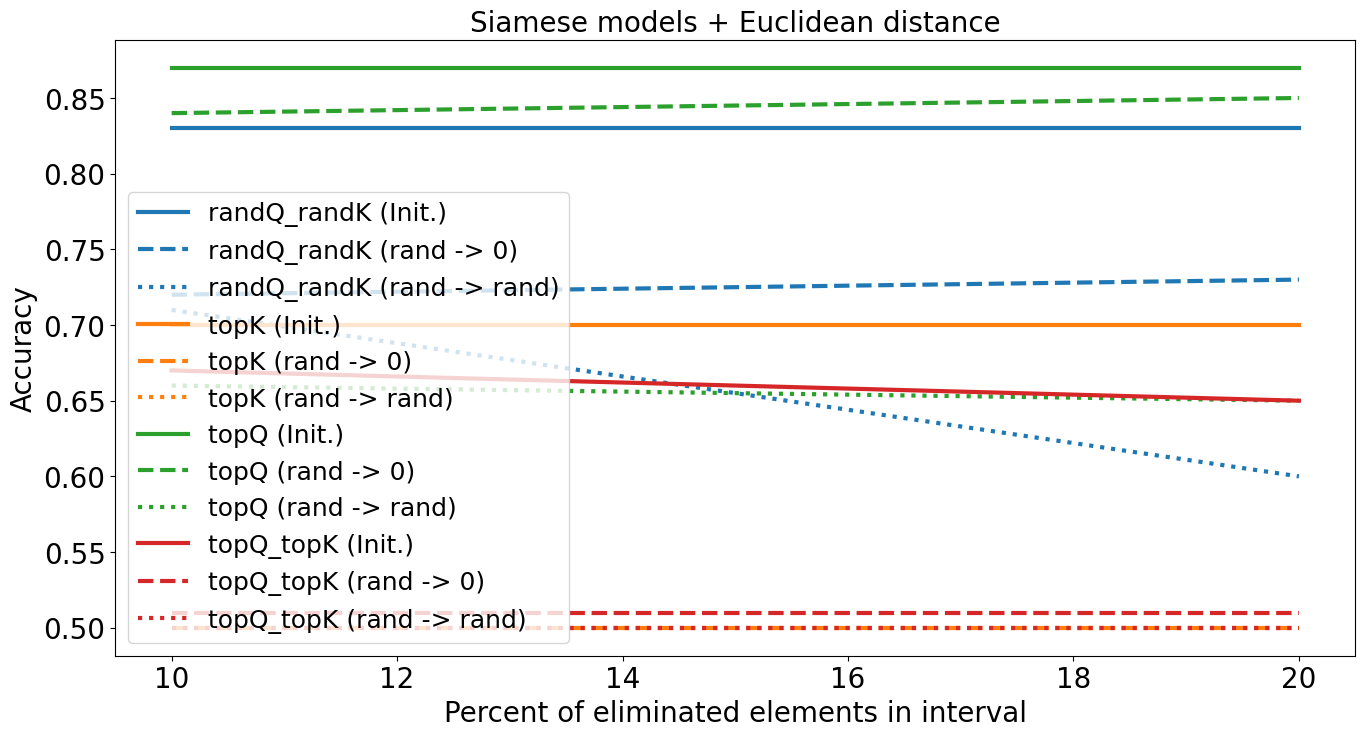

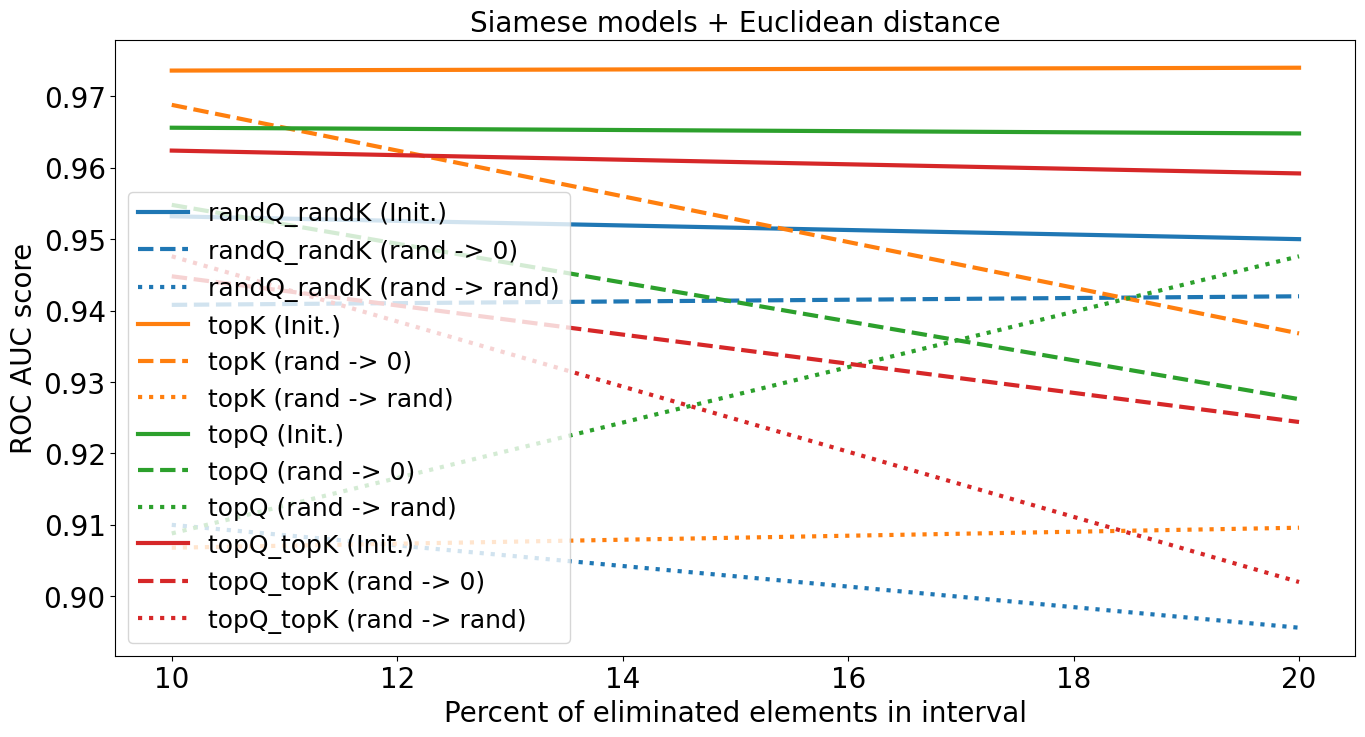

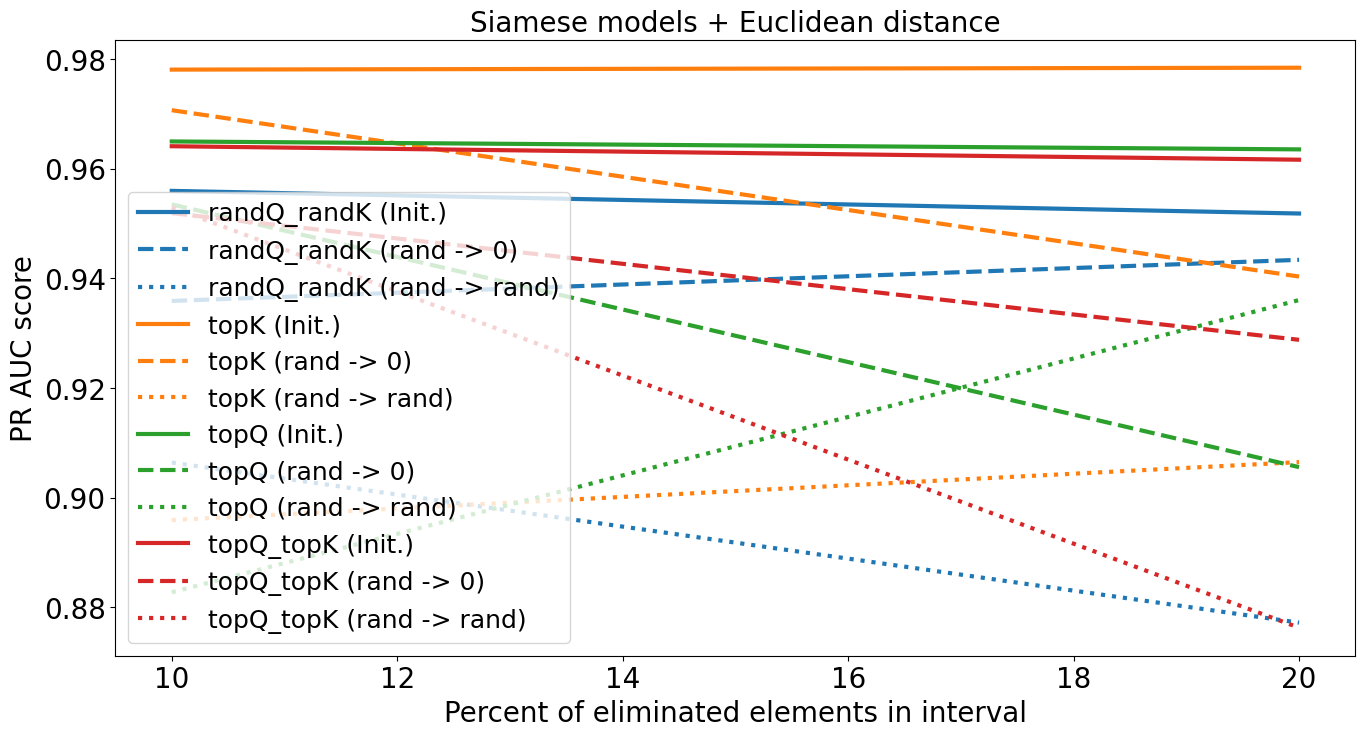

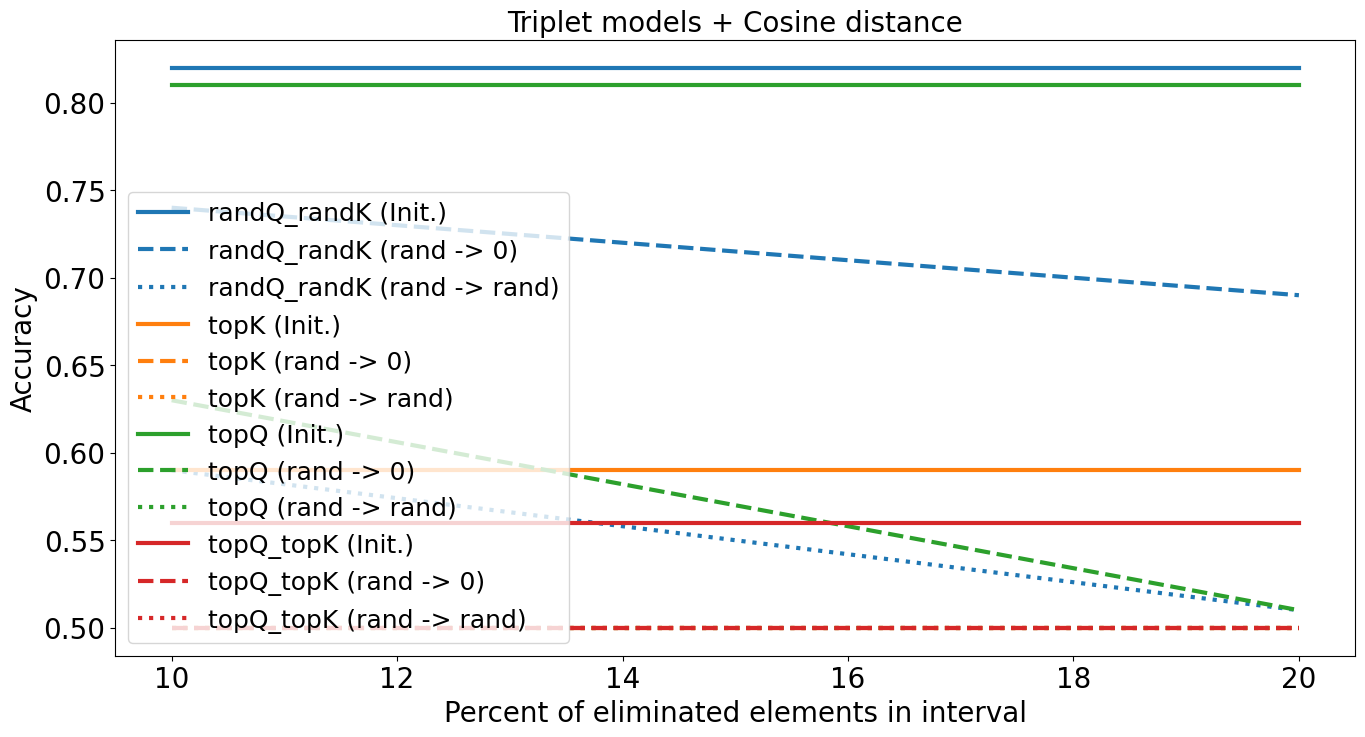

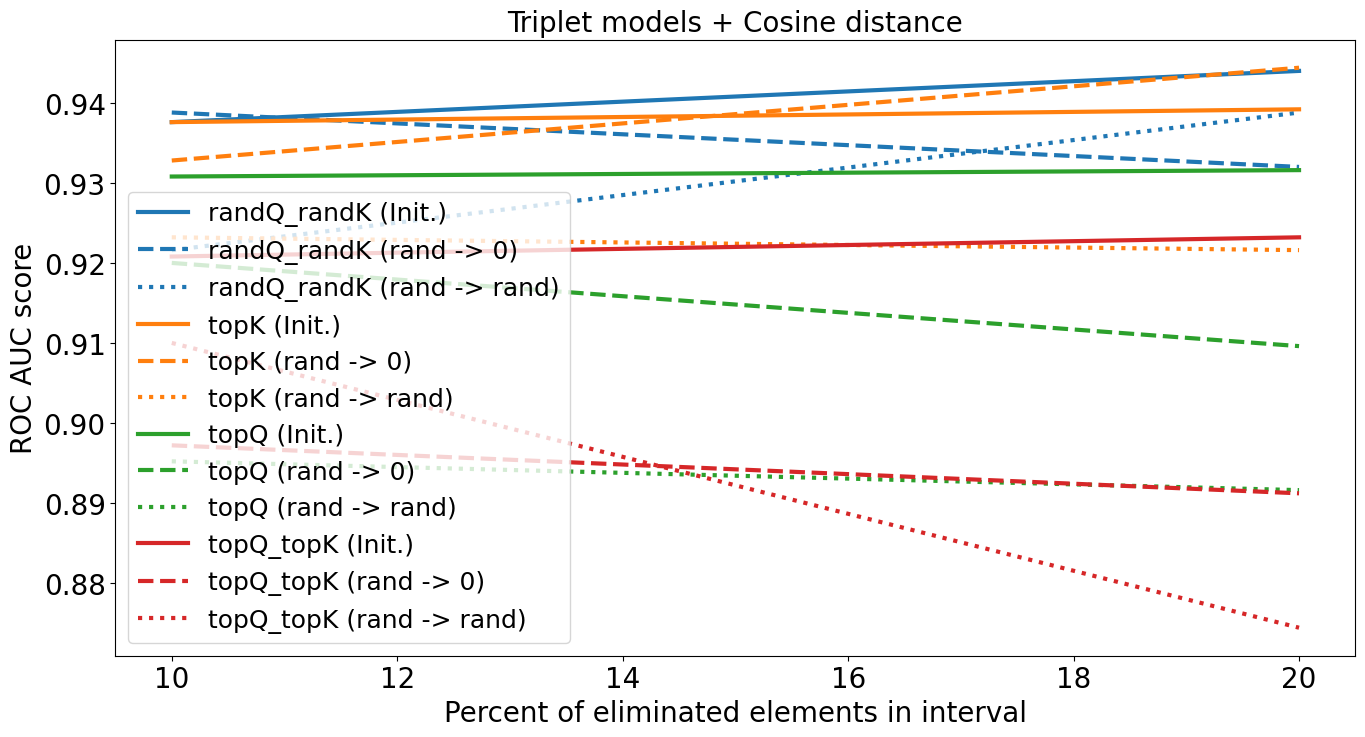

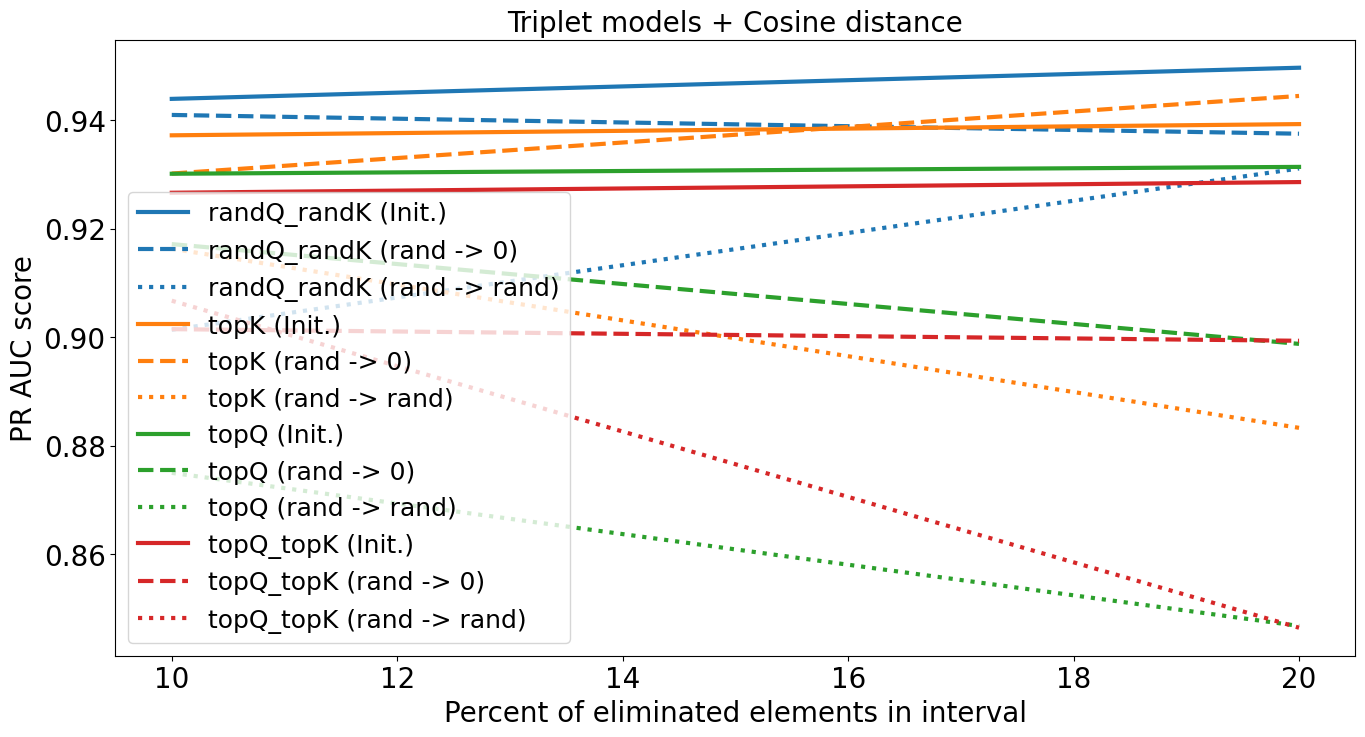

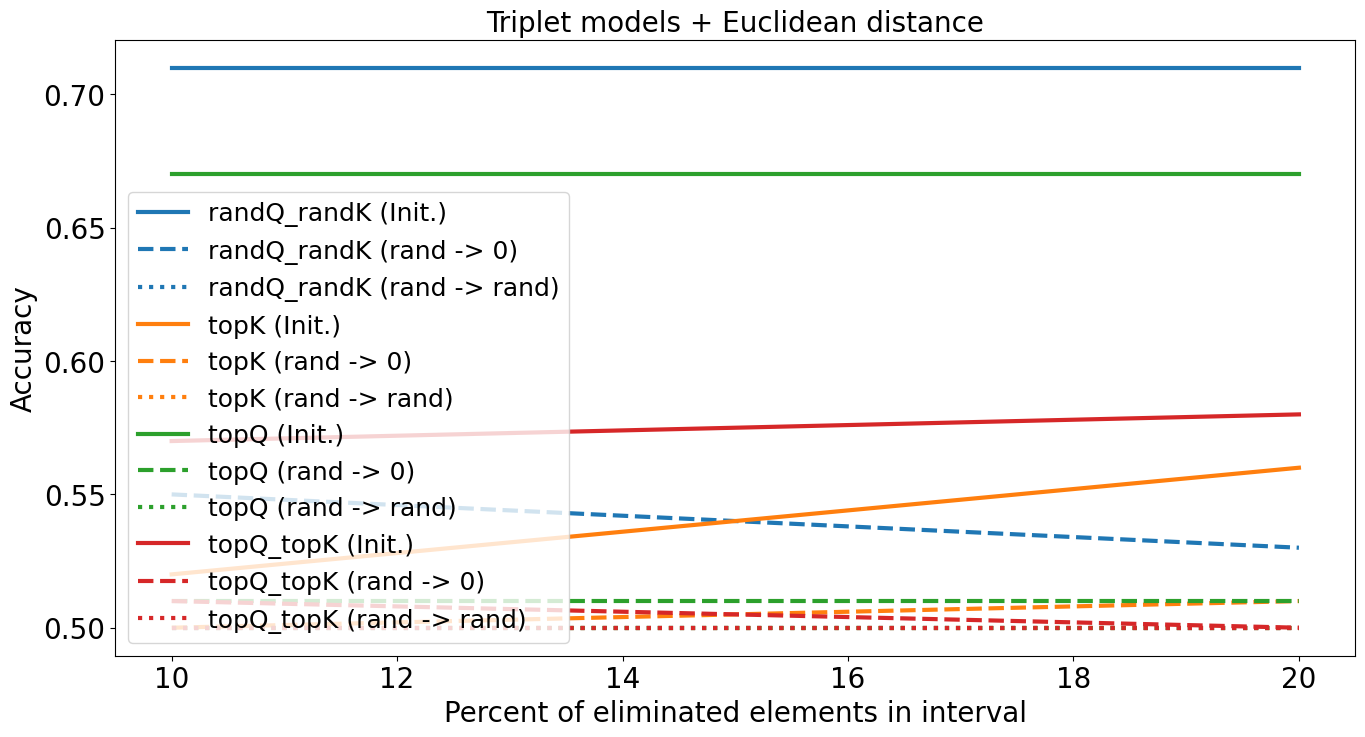

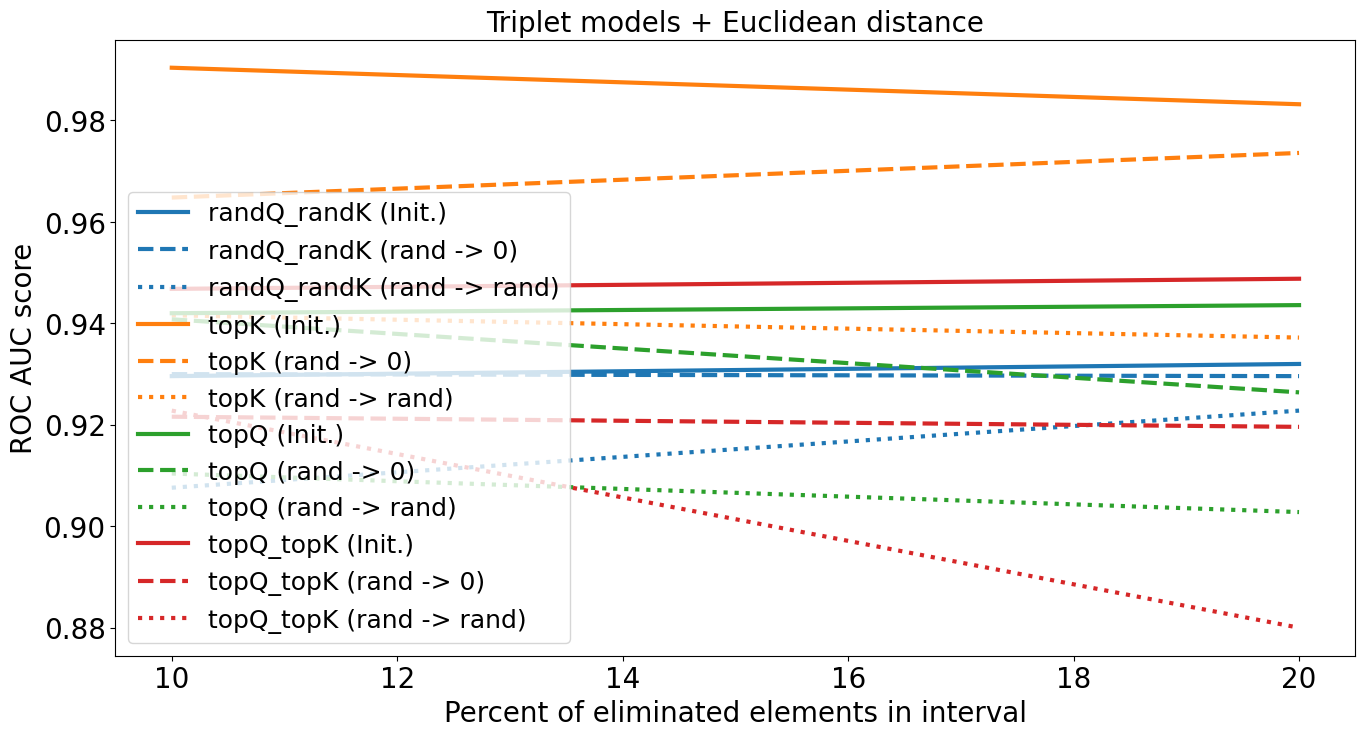

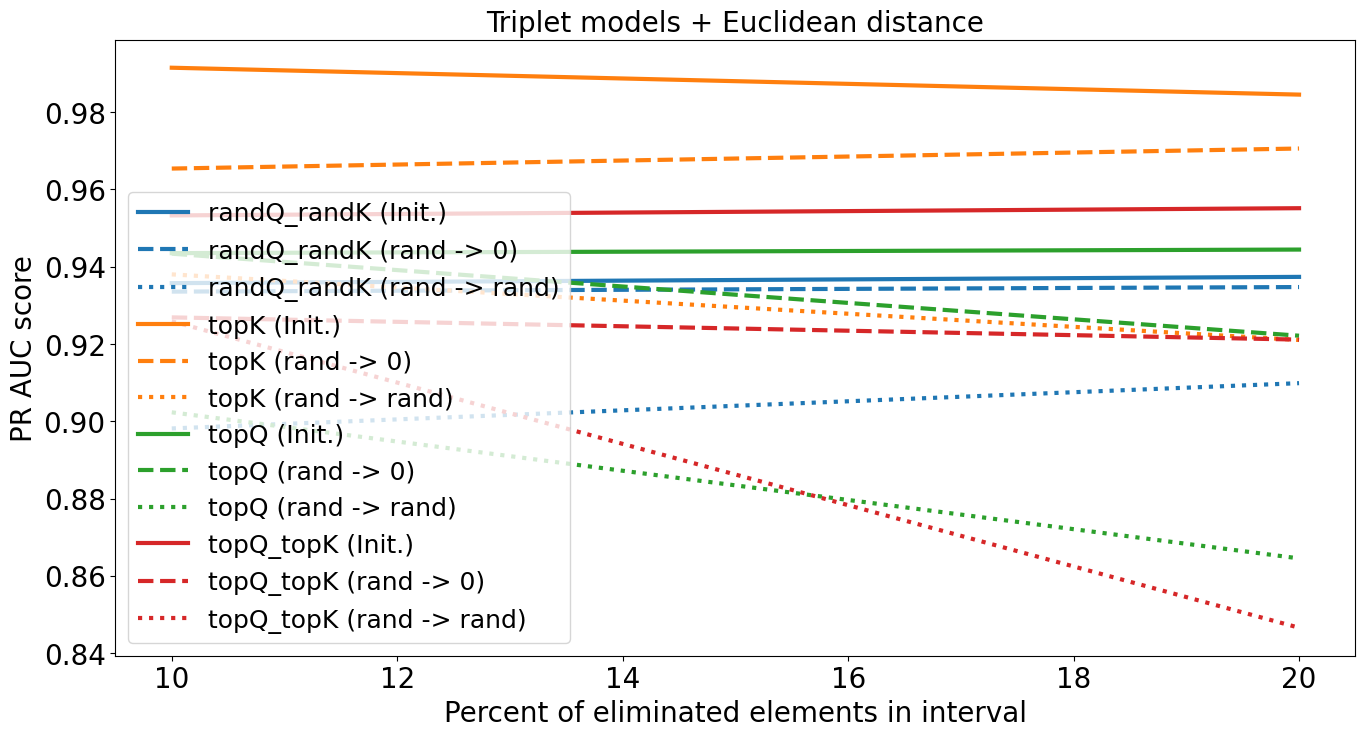

In [54]:
markers = ['o', 'x', '^', 'D', 'v', 's']
elim_type_dict = {
    "init": "Init.",
    "rand_rand": "rand -> rand",
    "rand_0": "rand -> 0",
}
model_type_dict = {
    "siamese": "Siamese",
    "triplet": "Triplet",
}
dist_type_dict = {
    "None": "3 FC",
    "euclidean": "Euclidean distance",
    "cosine": "Cosine distance",
}
line_styles = ["solid", "dashed", "dotted", "dashdot"]


for (loss_type, dist_type), data in ans_df.groupby(by=["loss_type", "distance_type"]):
    for metric_name, metric_label in zip(
        ["acc", "roc_auc", "pr_auc"],
        ["Accuracy", "ROC AUC score", "PR AUC score"],
    ):
        plt.figure(figsize=(16, 8))

        c = 0
        for i, (reg_type, df1) in tqdm(enumerate(data.groupby(by='reg_type'))):
            for j, (elim_type, df2) in enumerate(df1.groupby(by='elimination_type')):
                means, stds = [], []
                for p, df3 in df2.groupby(by='p'):
                    means.append(df3[metric_name].values.mean())
                    stds.append(df3[metric_name].values.std())
                
                means = np.array(means)
                stds = np.array(stds)
                
                plt.plot(
                    P,
                    means,
                    label="{} ({})".format(reg_type, elim_type_dict[elim_type]),
                    c="C{}".format(c),
                    ls=line_styles[j],
                    lw=3,
                )
            c += 1
            
        plt.legend(loc='lower left');
        plt.xlabel('Percent of eliminated elements in interval');
        plt.ylabel(metric_label);
        plt.title("{} models + {}".format(model_type_dict[loss_type], dist_type_dict[dist_type]))

        plt.savefig(os.path.join(path_to_save, 'robustness_all_models_{}_{}_{}.pdf'.format(metric_name, loss_type, dist_type)), dpi=500, bbox_inches='tight')
        plt.savefig(os.path.join(path_to_save, 'robustness_all_models_{}_{}_{}.png'.format(metric_name, loss_type, dist_type)), dpi=500, bbox_inches='tight')

# Correlation between attention and gradients of Transformers

In [55]:
shared_fixed_params = {
    "enc_in": 4,
    "distil": None,
    "device": device,
    "output_attention": True,
    "n_seq": 100
}

In [56]:
corr_coefs = {"siamese": []} #, "triplet": []}

for loss_type in ["siamese"]: #, "triplet"]:
    with open(os.path.join(path_to_models, "best_params_{}_reguformer_None.json".format(loss_type)), "r") as f:
        best_params = json.load(f)

    if "siamese" in loss_type:
        model = utils_model.SiameseArchitecture(
            encoder_type="reguformer", 
            fc_hidden_size=64, 
            **shared_fixed_params, 
            **fixed_params_tr,
            **best_params,
        ).float()

    elif "triplet" in loss_type:
        model = utils_model.TripletArchitecture(
            encoder_type="reguformer", 
            **shared_fixed_params, 
            **fixed_params_tr,
            **best_params,
        ).float()

    print('loading model...')
    model.load_state_dict(torch.load(os.path.join(path_to_models, "res_{}_transformer.pth".format(loss_type)), map_location=device))
    print('model loaded')
    model.eval()

    for slice_1, _, _, well in tqdm(val_dataloader):
        _, _, gr_1, _ = utils_attn.get_gradients([slice_1, slice_1], model, loss_type, device="cpu", agg=True)
        a_1 = utils_attn.get_attention_scores(
            slice_1,
            model.encoder
        )

        corr_coefs[loss_type].append(
            utils_attn.calc_corr(gr_1, a_1)
        )

  0%|                                                                                    | 0/1 [00:00<?, ?it/s]

loading model...
model loaded


100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


In [57]:
corr_coefs_df = pd.DataFrame(corr_coefs)
corr_coefs_df.to_csv(os.path.join(path_to_save, 'corr_grads_attn_scores.csv'), index=False)
corr_coefs_df

,siamese
0,0.058995


In [58]:
print(
    np.nanmean(corr_coefs_df["siamese"].values),
    "±",
    np.nanstd(corr_coefs_df["siamese"].values)
)

0.05899452242966538 ± 0.0
